In [1]:
import numpy as np
import cv2
import struct
import math
import time
import os
import math
import time
import sys
import PIL
from models import *
import torchvision.transforms as transforms
from torch.autograd import Variable
#from models import *
import torch.nn as nn
import torch.nn.functional as F
import torch
from ssd import build_ssd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

In [2]:
n_class = 4
width = 640
height = 480
cuda = True if torch.cuda.is_available() else False
prob_threshold = 0.3
border = 0
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
data_transform = transforms.Compose([transforms.Resize((256, 256), PIL.Image.BICUBIC),
                transforms.ToTensor()])
net = build_ssd('test', 300, 4)    # initialize SSD
net.load_weights('/media/arg_ws3/5E703E3A703E18EB/ssd300_subt_280000.pth')
generator = GeneratorUNet(in_channels=3, out_channels=1)
generator_2ch = GeneratorUNet(in_channels=3, out_channels=2)
generator.load_state_dict(torch.load('/media/arg_ws3/5E703E3A703E18EB/research/pix2pix_cropmask/saved_models/rgb/generator_10.pth'))
generator_2ch.load_state_dict(torch.load('/media/arg_ws3/5E703E3A703E18EB/research/pix2pix_cropmask/saved_models/subt_pix/generator_20.pth'))
if cuda:
    net = net.cuda()
    generator = generator.cuda()
    generator_2ch = generator_2ch.cuda()

/home/arg_ws3/gan_rv/catkin_ws/src/classify/src/ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)
/home/arg_ws3/gan_rv/catkin_ws/src/classify/src/layers/modules/l2norm.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.weight,self.gamma)


Loading weights into state dict...
Finished!


In [3]:
def generate_image(bbx_img):
    bbx_img = cv2.cvtColor(bbx_img, cv2.COLOR_RGB2BGR)
    pil_im = PIL.Image.fromarray(bbx_img)
    pil_im = data_transform(pil_im)
    pil_im = pil_im.unsqueeze(0)
    my_img = Variable(pil_im.type(Tensor))
    my_img_fake = generator(my_img)
    my_img_fake = my_img_fake.squeeze(0).detach().cpu()
    pil_ = my_img_fake.mul(255).clamp(0, 255).byte().permute(1, 2, 0)
    pil_ = np.array(pil_)
    pil_ = pil_[...,::-1]
    #generate_img = cv2.resize(generate_img, (640, 480))
    #mask_dilate()
    #print("Hz: ", 1./(time.time() - prev_time))
    return pil_

In [4]:
def generate_image_2ch(bbx_img):
    bbx_img = cv2.cvtColor(bbx_img, cv2.COLOR_RGB2BGR)
    pil_im = PIL.Image.fromarray(bbx_img)
    pil_im = data_transform(pil_im)
    pil_im = pil_im.unsqueeze(0)
    my_img = Variable(pil_im.type(Tensor))
    my_img_fake = generator_2ch(my_img)
    my_img_fake = my_img_fake.squeeze(0).detach().cpu()
    pil_ = my_img_fake.mul(255).clamp(0, 255).byte().permute(1, 2, 0)
    pil_ = np.array(pil_)
    pil_ = pil_[...,::-1]
    #generate_img = cv2.resize(generate_img, (640, 480))
    #mask_dilate()
    #print("Hz: ", 1./(time.time() - prev_time))
    return pil_

In [5]:
def mask_dilate():
    mask = np.zeros(generate_img.shape, np.uint8)
    ret, mask = cv2.threshold(generate_img, 500, 255, cv2.THRESH_BINARY)
    mask = 255 - mask
    kernel = np.ones((10,10),np.uint8)
    mask = cv2.dilate(mask, kernel, iterations = 1)
    mask = 255 - mask
    for j in range(mask.shape[0]):
        for i in range(mask.shape[1]):
            if mask[j][i] == 0:
                generate_img[j][i] = 0

In [6]:
def show_img(img, pred):
    fig=plt.figure(figsize=(20, 20))
    fig.add_subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    fig.add_subplot(1,2,2)
    plt.imshow(pred)
    plt.show()

In [7]:
cv_image = cv2.imread("/media/arg_ws3/5E703E3A703E18EB/data/subt_tunnel_hsinchu/bag3/Images/users/andyser/subt_real/evl_data/bag3/1.jpg")

- predict: please use "tanh" activation function

In [10]:
def predict(image):
    h, w = image.shape[:2]
    tmp_img = image.copy()
    generate_img = np.zeros(image.shape, np.uint8)
    # generate_img = image.copy()
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    x = cv2.resize(img, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)

    #SSD Forward Pass
    xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
    if torch.cuda.is_available():
        xx = xx.cuda()
    y = net(xx)
    # print(1./(t2-t1))
    scale = torch.Tensor(image.shape[1::-1]).repeat(2)
    detections = y.data	# torch.Size([1, 4, 200, 5]) --> [batch?, class, object, coordinates]
    objs = []
    for i in range(detections.size(1)): # detections.size(1) --> class size
        for j in range(5):	# each class choose top 5 predictions
            if detections[0, i, j, 0].numpy() > prob_threshold:
                score = detections[0, i, j, 0]
                pt = (detections[0, i, j,1:]*scale).cpu().numpy()
                objs.append([pt[0], pt[1], pt[2]-pt[0]+1, pt[3]-pt[1]+1, i])
    for obj in objs:
        region = [int(obj[1] - border), int(obj[1] + obj[3] + border),\
                  int(obj[0] - border), int(obj[0] + obj[2] + border)]

        bbx_img = image[region[0] : region[1], region[2]: region[3]]
        if bbx_img.shape[0] == 0 or bbx_img.shape[1]==0:
            continue

        mask = generate_image(bbx_img)
        # lis = []
        # for i in range(mask.shape[0]):
        # 	for j in range(mask.shape[1]):
        # 		if mask[i][j] not in lis:
        # 			lis.append(mask[i][j])
        # print(lis)
        #print(mask.transpose(2,0,1).shape)
        #output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)
        #mask = mask.transpose(2, 0, 1).reshape(-1, 2).argmax(axis = 1).reshape(256, 256, 1)
        mask = cv2.resize(mask, (region[3]-region[2], region[1]-region[0]))
        
        # add class label to mask
        if obj[4] == 1: #extinguisher
            label = 1
        elif obj[4] == 2: #drill
            label = 3
        elif obj[4] == 3: #backpack
            label = 2
        ret, mask = cv2.threshold(mask, 100, label, cv2.THRESH_BINARY) # pixel value only belongs to 0 or 255
        
        if generate_img[region[0] : region[1], region[2]: region[3]].shape[:2] == mask.shape:
            generate_img[region[0] : region[1], region[2]: region[3]] = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    generate_img = generate_img[:,:,0]
    return generate_img

- predict_2ch: please use "sigmoid" activation function

In [30]:
def predict_2ch(image):
    h, w = image.shape[:2]
    tmp_img = image.copy()
    generate_img = np.zeros(image.shape, np.uint8)
    # generate_img = image.copy()
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    x = cv2.resize(img, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)

    #SSD Forward Pass
    xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
    if torch.cuda.is_available():
        xx = xx.cuda()
    y = net(xx)
    # print(1./(t2-t1))
    scale = torch.Tensor(image.shape[1::-1]).repeat(2)
    detections = y.data	# torch.Size([1, 4, 200, 5]) --> [batch?, class, object, coordinates]
    objs = []
    for i in range(detections.size(1)): # detections.size(1) --> class size
        for j in range(5):	# each class choose top 5 predictions
            if detections[0, i, j, 0].numpy() > prob_threshold:
                score = detections[0, i, j, 0]
                pt = (detections[0, i, j,1:]*scale).cpu().numpy()
                objs.append([pt[0], pt[1], pt[2]-pt[0]+1, pt[3]-pt[1]+1, i])
    for obj in objs:
        region = [int(obj[1] - border), int(obj[1] + obj[3] + border),\
                  int(obj[0] - border), int(obj[0] + obj[2] + border)]

        bbx_img = image[region[0] : region[1], region[2]: region[3]]
        if bbx_img.shape[0] == 0 or bbx_img.shape[1]==0:
            continue

        mask = generate_image_2ch(bbx_img)
        # lis = []
        # for i in range(mask.shape[0]):
        # 	for j in range(mask.shape[1]):
        # 		if mask[i][j] not in lis:
        # 			lis.append(mask[i][j])
        # print(lis)
        mask = mask.reshape(-1, 2).argmax(axis=1).reshape(256, 256).astype(np.uint8)
        mask = 1 - mask # conver 1 to 0, 0 to 1
        #mask[mask!=0] = 255
        mask = cv2.resize(mask, (region[3]-region[2], region[1]-region[0]))
        
        # add class label to mask
        if obj[4] == 1: #extinguisher
            label = 1
        elif obj[4] == 2: #drill
            label = 3
        elif obj[4] == 3: #backpack
            label = 2
        mask[mask!=0] = label
        #ret, mask = cv2.threshold(mask, 100, label, cv2.THRESH_BINARY) # pixel value only belongs to 0 or 255
        
        if generate_img[region[0] : region[1], region[2]: region[3]].shape[:2] == mask.shape:
            generate_img[region[0] : region[1], region[2]: region[3]] = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    generate_img = generate_img[:,:,0]
    return generate_img
#generate_img = predict_2ch(cv_image)
#show_img(cv_image, generate_img)

(480, 640)
(480, 640)


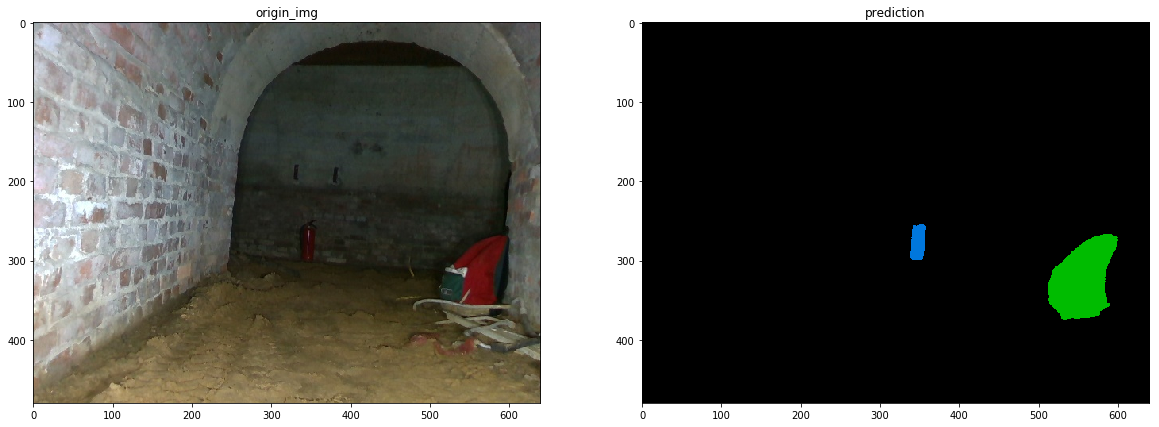

In [40]:
cv_image = cv2.imread("/media/arg_ws3/5E703E3A703E18EB/data/subt_tunnel_hsinchu/bag3/Images/users/andyser/subt_real/evl_data/bag3/5.jpg", cv2.IMREAD_UNCHANGED)
label = cv2.imread("/media/arg_ws3/5E703E3A703E18EB/data/subt_tunnel_hsinchu/bag3/Masks/users/andyser/subt_real/evl_data/bag3/5.png", cv2.IMREAD_UNCHANGED)
print(label.shape)
pred = predict_2ch(cv_image)
print(pred.shape)
fig=plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.title("origin_img")
plt.imshow(cv_image[:, :, ::-1]) #RGB2BGR
#print(img.shape, pred[0].shape)
#print(np.unique(_img[i]))

plt.subplot(1, 2, 2)
plt.title("prediction")
plt.imshow(pred,cmap = "nipy_spectral",vmin = 0, vmax = 4)

plt.show()
cmap = plt.cm.nipy_spectral
norm = plt.Normalize(vmin=pred.min(), vmax=4)
image = cmap(norm(pred))
label = cmap(norm(label))
plt.imsave('/home/arg_ws3/Desktop/thesis/image/subt_ssd_gan.png', image)
plt.imsave('/home/arg_ws3/Desktop/thesis/image/subt_label.png', label)
plt.imsave('/home/arg_ws3/Desktop/thesis/image/subt_rgb.png', cv_image[:, :, ::-1])

In [10]:
#im = np.ones((480, 640, 3))*100
im = np.zeros((480, 640, 3))
for i in range(generate_img.shape[0]):
    for j in range(generate_img.shape[1]):
        if generate_img[i][j] == 1:
            im[i][j][0] = 255
        elif generate_img[i][j] == 2:
            im[i][j][1] = 255
        elif generate_img[i][j] == 3:
            im[i][j][2] = 255
cv2.imwrite("pred_gan.jpg", im)
cv2.imwrite("orig_gan.jpg", cv_image)

True

extinguisher: 1

drill: 3

backpack: 2

In [11]:
def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)
    
    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

- Use predict(input_img) for 1 channel output version
- Use predict_2ch(input_img) for 2 channel output version

In [12]:
def val(data_dir, score_dir, name, val_txt):
    #score_dir = "/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/scores/gan_ssd_622"
    if not os.path.exists(score_dir):
        os.makedirs(score_dir)
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    data_list = []
    
    csv_data = pd.read_csv(val_txt)
    for idx in range(len(csv_data)):
        img_name = csv_data.iloc[idx, 0]
        label_name = csv_data.iloc[idx, 1]
        input_img = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
        target = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
        
        # Change your prediction here
        pred = predict_2ch(input_img)

        h, w = pred.shape

        pixel_accs.append(pixel_acc(pred, target))
        _TP, _FN, _FP =  analysis(pred, target, h, w)
        TP += _TP[1:n_class]
        FN += _FN[1:n_class]
        FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("name: {}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(name, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('name:'+ str(name) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('name:'+ str(name) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('name:'+ str(name) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('name:'+ str(name) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('name:'+ str(name) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('name:'+ str(name) + ', class fscore: ' + str(fscore) + '\n' )
    f7 = open(score_dir + "/mean_fscore_log.txt","a+")
    f7.write('name:'+ str(name) + ', mean fscore: ' + str(np.nanmean(fscore)) + '\n' )
    f8 = open(score_dir + "/mean_precision_log.txt","a+")
    f8.write('name:'+ str(name) + ', mean precision: ' + str(np.nanmean(precision)) + '\n' ) 
    f9 = open(score_dir + "/mean_recall_log.txt","a+")
    f9.write('name:'+ str(name) + ', mean recall: ' + str(np.nanmean(recall)) + '\n' ) 

In [13]:
data_dir = '/media/arg_ws3/5E703E3A703E18EB/data/subt_tunnel_hsinchu/'
val_txt = '/media/arg_ws3/5E703E3A703E18EB/data/subt_tunnel_hsinchu/test.csv'
score_dir = "/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/scores/gan_ssd_18mnt"
name = 'gan_ssd_18mnt_2ch_epoch8'

In [14]:
val(data_dir, score_dir, name, val_txt)

name: gan_ssd_18mnt_2ch_epoch8, pix_acc: 0.9964512648809523, meanIoU: 0.6868507352441664, IoUs: [0.52518115 0.71136155 0.82400951], recall: [0.85093183 0.75633977 0.95952047], precision: [0.57839488 0.92285162 0.85368593], fscore: [0.68868036 0.83133988 0.90351449]
